In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/vision

/content/drive/MyDrive/Colab Notebooks/vision


In [ ]:
# # to execute py file
# !python rap.py

"""Method for generating saliency maps for object detection models."""


In [ ]:
import base64
from io import BytesIO
from typing import Optional, Tuple
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import requests
import torch
import torchvision
from PIL import Image
from torchvision import transforms as T
from torchvision.models import detection

In [ ]:
import visualization as viz
#from image_model_wrapper import (MLflowDRiseWrapper,PytorchDRiseWrapper)
from rap import (MLflowDRiseWrapper,PytorchDRiseWrapper)
import drise

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:

try:
    from matplotlib.axes._subplots import AxesSubplot
except ImportError:
    # For matplotlib >= 3.7.0
    from matplotlib.axes import Subplot as AxesSubplot

In [ ]:
IMAGE_TYPE = ".jpg"

In [ ]:

def get_drise_saliency_map(imagelocation: str,model: Optional[object],numclasses: int,
        savename: Optional[str]=None,nummasks: int = 200,maskres: Tuple[int, int] = (4, 4),
        maskpadding: Optional[int] = None,devicechoice: Optional[str] = None,max_figures: Optional[int] = None):
# def get_drise_saliency_map(imagelocation: str,model: Optional[object],numclasses: int,
#         savename: Optional[str]=None,nummasks: int = 200,maskres: Tuple[int, int] = (4, 4),maskpadding: Optional[int] = None,
#                            devicechoice: Optional[str] = None,max_figures: Optional[int] = None):
  if not devicechoice:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  else:
        device = devicechoice
  if not model:
        unwrapped_model = detection.fasterrcnn_resnet50_fpn(pretrained=True, map_location=device)
        unwrapped_model.to(device)
        model = PytorchDRiseWrapper(unwrapped_model, numclasses)
  image_open_pointer = imagelocation

  if (imagelocation.startswith("http://")or imagelocation.startswith("https://")):
        response = requests.get(imagelocation)
        image_open_pointer = BytesIO(response.content)
  test_image = Image.open(image_open_pointer).convert('RGB')

  if isinstance(model, MLflowDRiseWrapper):
        x, y = test_image.size
        imgio = BytesIO()
        test_image.save(imgio, format='PNG')
        img_str = base64.b64encode(imgio.getvalue()).decode('utf8')
        img_input = pd.DataFrame(data=[[img_str, (y, x)]],columns=['image', 'image_size'],)

        detections = model.predict(img_input)
        saliency_scores = drise.DRISE_saliency_for_mlflow(model=model,image_tensor=img_input,
            target_detections=detections,number_of_masks=nummasks,mask_padding=maskpadding,
            device=device,mask_res=maskres,verbose=True)
  else:
    img_input = test_image
    if hasattr(model, "transforms") and model.transforms is not None:
       img_input = model.transforms(img_input)
    if not torch.is_tensor(img_input):
       img_input = T.ToTensor()(img_input)
    img_input = img_input.unsqueeze(0).to(device)
    detections = model.predict(img_input)

    saliency_scores = drise.DRISE_saliency( model=model,image_tensor=img_input, target_detections=detections,
            number_of_masks=nummasks, mask_padding=maskpadding,device=device,mask_res=maskres,verbose=True)

  img_index = 0
  # Filter out saliency scores containing nan values
  saliency_scores = [saliency_scores[img_index][i]
                     for i in range(len(saliency_scores[img_index]))
                     if not torch.isnan(saliency_scores[img_index][i]['detection']).any()]
  num_detections = len(saliency_scores)
  if num_detections == 0:
    raise ValueError("No detections found")
  label_list = []
  fig_list = []
  if max_figures is None:
    loop_limit = num_detections
  else:
    loop_limit = min(num_detections, max_figures)

  for i in range(loop_limit):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    label = int(torch.argmax(detections[img_index].class_scores[i]))
    label_list.append(label)

    viz.visualize_image_attr(numpy.transpose(
                saliency_scores[i]['detection'].cpu().detach().numpy(),(1, 2, 0)),
               numpy.transpose(T.ToTensor()(test_image).numpy(), (1, 2, 0)),
            method="blended_heat_map",sign="positive",show_colorbar=False,cmap='jet',
            title="Saliency" + str(i), plt_fig_axis=(fig, ax),use_pyplot=False)
    stream = BytesIO()
    plt.savefig(stream, format='jpg')
    stream.seek(0)
    b64_string = base64.b64encode(stream.read()).decode()
    fig_list.append(b64_string)
    #fig.savefig(savename+str(i)+IMAGE_TYPE)
    fig.clear()
  return fig_list, label_list


In [ ]:
import numpy as np
def show_saliency_maps(figures, labels):
    # Display saliency maps in the Colab cell
    for i, (fig_str, label) in enumerate(zip(figures, labels)):
        # Decode base64 and convert to NumPy array
        fig_bytes = base64.b64decode(fig_str)
        fig_image = Image.open(BytesIO(fig_bytes)).convert('RGB')
        fig_array = np.array(fig_image) / 255.0  # Normalize to [0, 1] range

        plt.figure(figsize=(10, 5))
        plt.title(f"Saliency {i} - Class {label}")
        plt.imshow(fig_array)
        plt.axis('off')
        plt.show()

In [ ]:
# calling the function
figures,labels = get_drise_saliency_map(imagelocation="laptop_man.jpg", model=None, numclasses=91)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 199/199 [00:00<00:00, 547.46it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

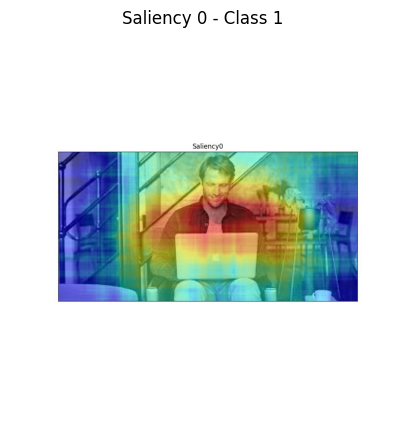

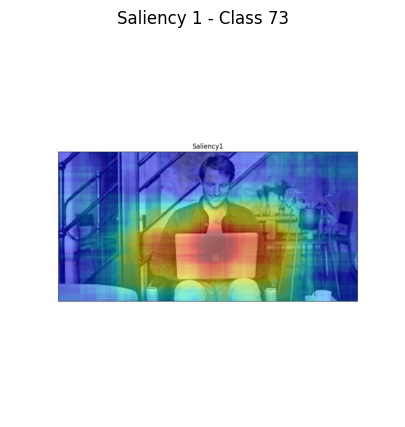

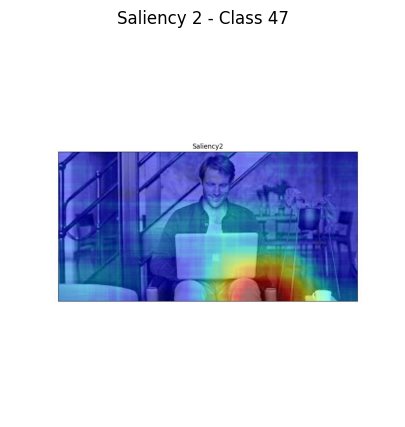

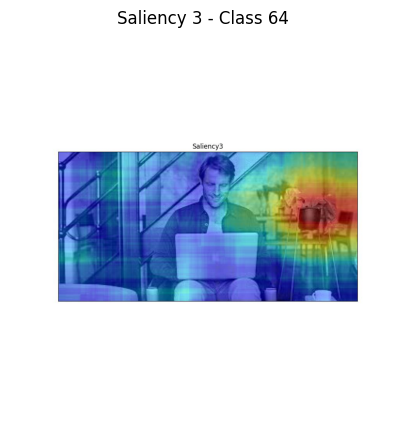

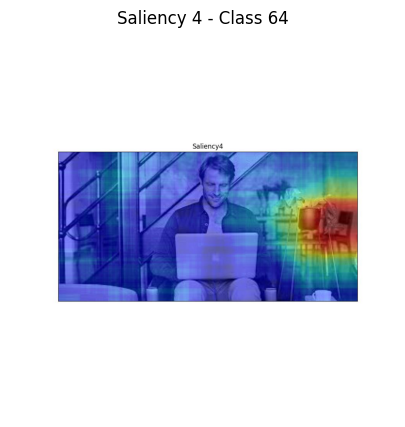

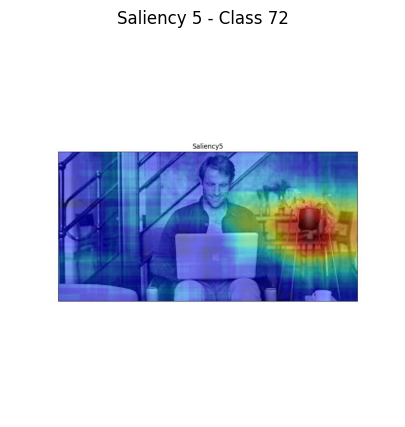

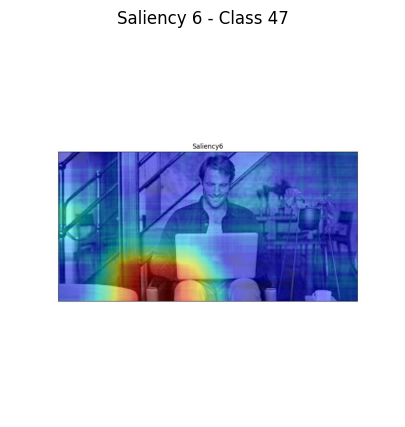

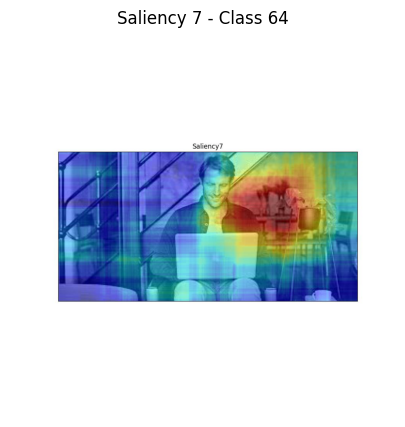

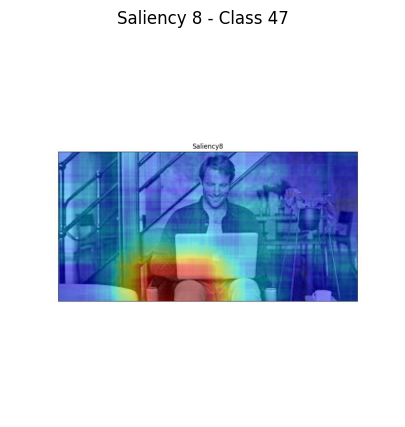

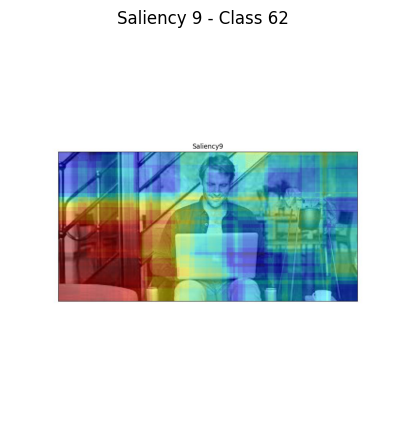

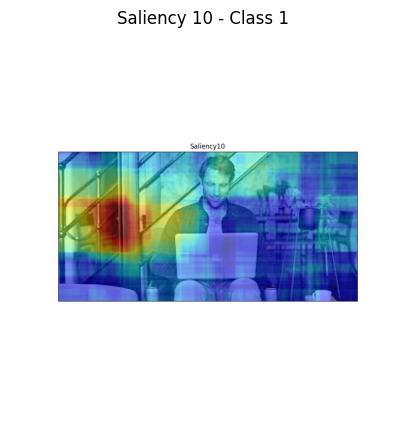

In [ ]:
# Show saliency maps
show_saliency_maps(figures, labels)